In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import collections
import time
import seaborn as sns
""" SCIKIT-LEARN """
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
import joblib
import gc


pd.set_option('display.float_format', lambda x: '%.5f' % x) # No scientic notation
pd.set_option('display.max_columns', 100)
import warnings
# Filter out specific ValueWarnings from statsmodels
warnings.filterwarnings("ignore")

# Preprocessing

**Code Explanation:**

- The function `timestamp_UTC_conversion` is designed to convert a timestamp column in a DataFrame to separate date and time columns.
- If the specified `date_col` is 'date', it is renamed to 'date_' to avoid potential conflicts.
- The timestamp column is transformed into a datetime format using `pd.to_datetime`.
- Two new columns, 'date' and 'time', are created by extracting the date and time components from the transformed timestamp.
- The original timestamp column is dropped if its name was changed.
- The modified DataFrame is returned.

In [2]:
def timestamp_UTC_conversion(train, date_col):
    # To avoid bugs: Rename 'date' column to 'date_' if it's originally named 'date'
    if date_col == 'date':
        train = train.rename(columns={'date': 'date_'})
        date_col = 'date_'
            
    # Transform the timestamp column to datetime format
    train[date_col] = pd.to_datetime(train[date_col])
    
    # Extract 'date' and 'time' components
    train['date'] = train[date_col].dt.date
    train['time'] = train[date_col].dt.time

    # Drop the original timestamp column if its name was changed
    if date_col != 'date_':
        train = train.drop(columns=[date_col])

    return train

**Code Explanation:**

- The function `process_date` takes a DataFrame (`train`), a column representing dates (`date_col`), an optional prefix (`prefixe`), and a flag to indicate whether to extract additional date features (`extract_features`).
  
- It converts the specified date column to string format (`train[date_col] = train[date_col].astype(str)`) to avoid datetime errors.
  
- Performs polar UTC conversion using a function called `timestamp_UTC_conversion`.
  
- Concatenates the 'date' and 'time' columns into a new 'date_col' column.
  
- If `extract_features` is set to `True`, additional date-related features are extracted.
  
- Extracted date features include year, month, day, day of the week, hour, minutes, and seconds.
  
- Day of the week is calculated based on the extracted year, month, and day.
  
- If a prefix is provided (`prefixe`), the extracted features are renamed with the specified prefix.
  
- Columns related to the original date are dropped if not needed.
  
- The processed DataFrame is returned.

In [3]:
# Code adapted from Kaggle notebook: [https://www.kaggle.com/code/vincentschuler/enefit-baseline-cross-validation]
# Function for processing date column
def process_date(train, date_col, prefixe='', extract_features=False):
    # Force to str (to avoid datetime error)
    train[date_col] = train[date_col].astype(str)
    
    # Polar UTC conversion
    train = timestamp_UTC_conversion(train, date_col)
    
    # Convert to string
    train['date'] = train['date'].astype(str)
    train['time'] = train['time'].astype(str)
    train[date_col] = train['date'] + ' ' + train['time']
    
    # Features extraction
    if extract_features:
        # Date features
        train['year'] = (train['date'].apply(lambda x: x[:4]).astype(int)).astype(int)
        train['month'] = train['date'].apply(lambda x: x[5:7]).astype(int)
        train['day'] = train['date'].apply(lambda x: x[8:10]).astype(int)
        
        # Day of week
        train['dayofweek'] = train[['year', 'month', 'day']].apply(
            lambda row: datetime(row['year'], row['month'], row['day']).weekday(), axis=1
        )
        
        # Time features
        train['hour'] = train['time'].apply(lambda x: x[:2]).astype(int)
        train['minutes'] = train['time'].apply(lambda x: x[3:5]).astype(int)
        train['seconds'] = train['time'].apply(lambda x: x[6:7]).astype(int)
        
        # Rename columns with prefix
        if len(prefixe) > 0:
            cols = ['year', 'month', 'day', 'hour', 'minutes', 'seconds']
            train = train.rename(columns={k: f"{prefixe}_{k}" for k in cols})

    # Drop unnecessary columns
    # train.drop(columns=[date_col], inplace=True)

    # Return the processed DataFrame
    return train

**Code Explanation:**

- The function `reduce_memory_usage` takes a DataFrame (`df`) as input and aims to reduce its memory usage by adjusting the data types of columns.
- If `print_info` is set to `True`, the function prints information about the memory before and after the reduction, as well as the percentage decrease.
- It iterates through each column in the DataFrame.
- For numerical columns (`col_type != object`):
  - It checks the minimum and maximum values in the column (`c_min` and `c_max`).
  - Converts the column data type to a smaller integer type (e.g., `np.int8`, `np.int16`, `np.int32`, `np.int64`) if the values fit within the new type's range.
  - Converts the column data type to a smaller float type (e.g., `np.float16`, `np.float32`) if the values fit within the new type's range.
- For object columns (`col_type == object`), it converts the data type to the 'category' type.
- If `print_info` is `True`, the function prints memory usage information before and after the reduction.

In [4]:
# Code adapted from Kaggle notebook: [https://www.kaggle.com/code/vincentschuler/enefit-baseline-cross-validation]
# Function to reduce memory usage of a DataFrame by adjusting column data types
def reduce_memory_usage(df, print_info=False):
    """ Iterate through columns, modify data types to reduce memory usage. """
    
    # Print memory information before reduction if specified
    if print_info:
        print('*'*50)
        start_mem = df.memory_usage().sum() / 1024**2
        print('Memory before : {:.2f} MB'.format(start_mem))

    # Iterate through columns for memory reduction
    for col in df.columns:
        col_type = df[col].dtype
        
        # Check and modify numerical column data types
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                # Convert to smaller integer type if values fit within the range
                # (e.g., np.int8, np.int16, np.int32, np.int64)
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                # Convert to smaller float type if values fit within the range
                # (e.g., np.float16, np.float32)
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            # Convert object columns to 'category' type
            df[col] = df[col].astype('category')

    # Print memory information after reduction if specified
    if print_info:
        end_mem = df.memory_usage().sum() / 1024**2
        print('Memory after  : {:.2f} MB'.format(end_mem))
        print('Decreased by  : {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        print('*'*50 + '\n')
    
    return df

In [5]:
# Read the CSV file
train = pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\train.csv")

print(train.shape)
train.head(2)

(2018352, 9)


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.71300,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.59000,1,2021-09-01 00:00:00,0,1,0


In [6]:
%%time

# Date processing + features extraction
for date_col in ['datetime'] :
    train = process_date(train, date_col, extract_features = True)

# Show
print(train.shape)
train.head(2)

(2018352, 18)
CPU times: total: 30.9 s
Wall time: 40.8 s


,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id,date,time,datetime,year,month,day,dayofweek,hour,minutes,seconds
0,0,0,1,0.71300,0,0,0,0,2021-09-01,00:00:00,2021-09-01 00:00:00,2021,9,1,2,0,0,0
1,0,0,1,96.59000,1,0,1,0,2021-09-01,00:00:00,2021-09-01 00:00:00,2021,9,1,2,0,0,0


In [7]:
# Count the occurrences of each unique datetime value in the 'datetime' column
datetime_counts = train['datetime'].value_counts()

# Convert the result into a DataFrame for better structure
datetime_counts_df = datetime_counts.to_frame()

# Sort the DataFrame based on datetime index for better readability
sorted_datetime_counts = datetime_counts_df.sort_index()

# The resulting DataFrame 'sorted_datetime_counts' now contains counts of occurrences for each unique datetime value.


count   2017824.00000
mean        274.85556
std         909.50238
min           0.00000
25%           0.37800
50%          31.13300
75%         180.20625
max       15480.27400
Name: target, dtype: float64

<Axes: >

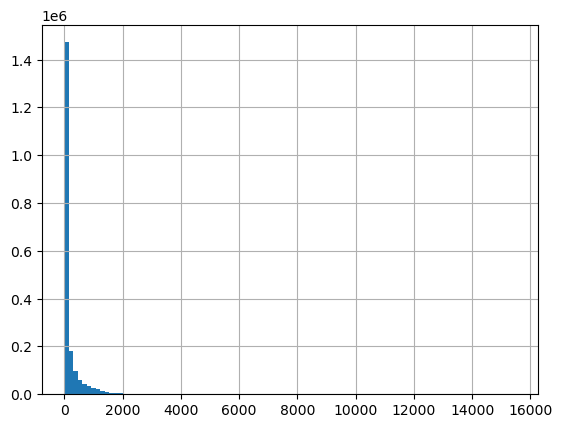

In [8]:
# Show target distribution
display(train['target'].describe())
train['target'].hist(bins=100)

The Tweedie distribution is commonly encountered in insurance and finance settings where the response variable is often a combination of a point mass at zero and a continuous distribution, typically modeled as a gamma distribution. As such, generalized linear models (GLMs) with a Tweedie family are commonly used for modeling such data.

**Code Explanation:**

- `N_TARGETS_REVEALED = 14`: Defines the number of days into the future for which targets will be revealed.
- `for day_shift in range(2, N_TARGETS_REVEALED+3)`: Iterates over a range of days to create lag features for the targets.

Inside the loop:
- `train['data_block_id_shifted'] = train['data_block_id'] + day_shift`: Creates a shifted version of the 'data_block_id' by adding the current `day_shift`.
- `train = pd.merge(...)`: Merges the original 'train' DataFrame with a subset of itself, shifted by `day_shift` days. This is done based on specific columns and creates lag features for the target.
- `mask = train[f"target_revealed_{day_shift}days_ago"].isna()`: Creates a mask for NaN values in the lagged target column.
- `train.loc[mask, f"target_revealed_{day_shift}days_ago"] = train.loc[mask, "target"]`: Fills NaN values in the lagged target column with the corresponding values from the 'target' column.

After the loop:
- `train.drop(columns=['data_block_id_shifted'], inplace=True)`: Removes the temporarily created column 'data_block_id_shifted' as it is no longer needed.

In [9]:
# Code adapted from Kaggle notebook: [https://www.kaggle.com/code/vincentschuler/enefit-baseline-cross-validation]
# Define the number of days into the future for which targets will be revealed
N_TARGETS_REVEALED = 14

# Iterate over a range of days to create lag features for the targets
for day_shift in range(2, N_TARGETS_REVEALED + 3):

    # Create a shifted version of 'data_block_id' by adding the current day_shift
    train['data_block_id_shifted'] = train['data_block_id'] + day_shift
    
    # Merge the original DataFrame with a subset of itself, creating lag features for the target
    train = pd.merge(
        train,
        train[["county", "is_business", "product_type", "is_consumption", "time", "data_block_id_shifted", "target"]]
        .rename(columns={"data_block_id_shifted": "data_block_id", "target": f"target_revealed_{day_shift}days_ago"}),
        how='left',
        on=["county", "is_business", "product_type", "is_consumption", "time", "data_block_id"]
    )

    # Fill NaN values in the lagged target column with corresponding values from the 'target' column
    mask = train[f"target_revealed_{day_shift}days_ago"].isna()
    train.loc[mask, f"target_revealed_{day_shift}days_ago"] = train.loc[mask, "target"]

# Drop the temporarily created column as it is no longer needed
train.drop(columns=['data_block_id_shifted'], inplace=True)

# Display the shape of the modified DataFrame
print(train.shape)

# Display the last two rows of the DataFrame
train.tail(2)

(2018352, 33)


,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id,date,time,datetime,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,target_revealed_8days_ago,target_revealed_9days_ago,target_revealed_10days_ago,target_revealed_11days_ago,target_revealed_12days_ago,target_revealed_13days_ago,target_revealed_14days_ago,target_revealed_15days_ago,target_revealed_16days_ago
2018350,15,1,3,0.00000,0,637,2018350,60,2023-05-31,23:00:00,2023-05-31 23:00:00,2023,5,31,2,23,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2018351,15,1,3,196.24000,1,637,2018351,60,2023-05-31,23:00:00,2023-05-31 23:00:00,2023,5,31,2,23,0,0,177.05600,161.65000,183.75600,189.93300,188.68900,195.70700,224.02100,238.82900,162.33700,167.09500,186.23800,201.47700,170.89000,176.77800,170.73500


In [10]:
# Create a copy of the 'train' DataFrame to avoid modifying the original data
df = train.copy()

# Display the shape (number of rows and columns) of the copied DataFrame
print(df.shape)

# Display the first 2 rows of the copied DataFrame to inspect the data
df.head(2)

(2018352, 33)


,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id,date,time,datetime,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,target_revealed_8days_ago,target_revealed_9days_ago,target_revealed_10days_ago,target_revealed_11days_ago,target_revealed_12days_ago,target_revealed_13days_ago,target_revealed_14days_ago,target_revealed_15days_ago,target_revealed_16days_ago
0,0,0,1,0.71300,0,0,0,0,2021-09-01,00:00:00,2021-09-01 00:00:00,2021,9,1,2,0,0,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300
1,0,0,1,96.59000,1,0,1,0,2021-09-01,00:00:00,2021-09-01 00:00:00,2021,9,1,2,0,0,0,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000


In [11]:
# Read electricity prices data from a CSV file
electricity_prices = pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\electricity_prices.csv")

# Date processing + features extraction
for date_col in ['forecast_date', 'origin_date']:
    # Utilize a function named process_date to handle date processing and feature extraction
    electricity_prices = process_date(electricity_prices, date_col)

# Display the shape of the resulting DataFrame
# This provides information about the number of rows and columns in the dataset
print(electricity_prices.shape)

# Display the first two rows of the DataFrame
# This helps in visually inspecting the processed data
electricity_prices.head(2)


(15286, 6)


,euros_per_mwh,data_block_id,date,time,forecast_date,origin_date
0,92.51000,1,2021-08-31,00:00:00,2021-09-01 00:00:00,2021-08-31 00:00:00
1,88.90000,1,2021-08-31,01:00:00,2021-09-01 01:00:00,2021-08-31 01:00:00


**A breakdown of what the code does:**

- **Shift Data Block IDs:**
  - It creates a new column 'data_block_id_shifted' in the 'electricity_prices' DataFrame by adding 2 to the existing 'data_block_id' values.
  
- **Merge DataFrames:**
  - It merges the main DataFrame 'df' with the modified 'electricity_prices' DataFrame based on the columns 'time' and 'data_block_id'.
  - The merge is performed using a left join, ensuring that all rows from 'df' are retained.

- **Result:**
  - The resulting DataFrame 'df' now contains an additional column 'euros_per_mwh' that represents electricity prices shifted by 2 days.


In [12]:
# Shift data_block_id (during the submission phase, the data are available 2 days ago)
electricity_prices['data_block_id_shifted'] = electricity_prices['data_block_id'] + 2

# Join electricity prices with the main DataFrame based on time and shifted data_block_id
df = pd.merge(
    df,
    electricity_prices[["time", "data_block_id_shifted", "euros_per_mwh"]].rename(columns={"data_block_id_shifted": "data_block_id"}),
    how='left',
    on=["time", "data_block_id"],
)

# Display the shape and first two rows of the resulting DataFrame
print(df.shape)
df.head(2)


(2018352, 34)


,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id,date,time,datetime,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,target_revealed_8days_ago,target_revealed_9days_ago,target_revealed_10days_ago,target_revealed_11days_ago,target_revealed_12days_ago,target_revealed_13days_ago,target_revealed_14days_ago,target_revealed_15days_ago,target_revealed_16days_ago,euros_per_mwh
0,0,0,1,0.71300,0,0,0,0,2021-09-01,00:00:00,2021-09-01 00:00:00,2021,9,1,2,0,0,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,NaN
1,0,0,1,96.59000,1,0,1,0,2021-09-01,00:00:00,2021-09-01 00:00:00,2021,9,1,2,0,0,0,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,NaN


In [13]:
# Read the CSV file into a Pandas DataFrame
gas_prices = pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\gas_prices.csv")

# Process dates and extract features for 'forecast_date' and 'origin_date'
for date_col in ['forecast_date', 'origin_date'] :
    gas_prices = process_date(gas_prices, date_col)
    
# Show
print(gas_prices.shape)
gas_prices.head(2)

(637, 7)


,lowest_price_per_mwh,highest_price_per_mwh,data_block_id,date,time,forecast_date,origin_date
0,45.23000,46.32000,1,2021-08-31,00:00:00,2021-09-01 00:00:00,2021-08-31 00:00:00
1,45.62000,46.29000,2,2021-09-01,00:00:00,2021-09-02 00:00:00,2021-09-01 00:00:00


In [14]:
# Calculate the shift in data_block_id (during submission, data is available 2 days ago)
gas_prices['data_block_id_shifted'] = gas_prices['data_block_id'] + 2

# Merge gas prices data with the main DataFrame based on time and shifted data_block_id
# This operation links gas prices information to the main DataFrame for the corresponding time and shifted data_block_id
cols = ['data_block_id_shifted', 'time', 'lowest_price_per_mwh', 'highest_price_per_mwh']
df = df.merge(gas_prices[cols].rename(columns={'data_block_id_shifted': 'data_block_id'}),
              how='left',
              on=["time", "data_block_id"],
             )

# Display the shape and the first two rows of the resulting DataFrame
print(df.shape)
df.head(2)


(2018352, 36)


,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id,date,time,datetime,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,target_revealed_8days_ago,target_revealed_9days_ago,target_revealed_10days_ago,target_revealed_11days_ago,target_revealed_12days_ago,target_revealed_13days_ago,target_revealed_14days_ago,target_revealed_15days_ago,target_revealed_16days_ago,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh
0,0,0,1,0.71300,0,0,0,0,2021-09-01,00:00:00,2021-09-01 00:00:00,2021,9,1,2,0,0,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,NaN,NaN,NaN
1,0,0,1,96.59000,1,0,1,0,2021-09-01,00:00:00,2021-09-01 00:00:00,2021,9,1,2,0,0,0,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,NaN,NaN,NaN


In [15]:
# Read client data from a CSV file
client = pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\client.csv")

# Rename the 'date' column to 'datetime'
client = client.rename(columns={'date': 'datetime'})

# Date processing and feature extraction
for date_col in ['datetime']:
    # Apply the process_date function to the 'datetime' column
    client = process_date(client, date_col)

# Fill any NaN values in the DataFrame with zeros
client.fillna(0, inplace=True)

# Display the shape and the first two rows of the DataFrame
print(client.shape)
client.head(2)


(41919, 9)


,product_type,county,eic_count,installed_capacity,is_business,data_block_id,date,time,datetime
0,1,0,108,952.89000,0,2,2021-09-01,00:00:00,2021-09-01 00:00:00
1,2,0,17,166.40000,0,2,2021-09-01,00:00:00,2021-09-01 00:00:00


In [16]:
%%time

# Shift data_block_id (during the submission phase, the data are available 2 days ago)
client['data_block_id_shifted'] = client['data_block_id'] + 2

# Join
df = df.merge(client.drop(columns=['date', 'datetime', 'data_block_id', 'time']).rename(columns={'data_block_id_shifted': 'data_block_id'}),
             how='left',
             on=['data_block_id', 'county', 'is_business', 'product_type'],
             )

# Show
print(df.shape)
df.head(2)


(2018352, 38)
CPU times: total: 453 ms
Wall time: 582 ms


,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id,date,time,datetime,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,target_revealed_8days_ago,target_revealed_9days_ago,target_revealed_10days_ago,target_revealed_11days_ago,target_revealed_12days_ago,target_revealed_13days_ago,target_revealed_14days_ago,target_revealed_15days_ago,target_revealed_16days_ago,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity
0,0,0,1,0.71300,0,0,0,0,2021-09-01,00:00:00,2021-09-01 00:00:00,2021,9,1,2,0,0,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.59000,1,0,1,0,2021-09-01,00:00:00,2021-09-01 00:00:00,2021,9,1,2,0,0,0,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,NaN,NaN,NaN,NaN,NaN


In [17]:
# Read county coordinates data from a CSV file
location = pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\county_lon_lats.csv").drop(columns=["Unnamed: 0"])

# Convert latitude and longitude to integers to avoid float imprecision
for k in ['latitude', 'longitude']:
    location[k] = (10 * location[k]).astype(int)

# Display the shape of the DataFrame and the first two rows
print(location.shape)
location.head(2)


(75, 3)


,county,longitude,latitude
0,0,242,591
1,0,252,591


In [18]:
# Code adapted from Kaggle notebook: [https://www.kaggle.com/code/vincentschuler/enefit-baseline-cross-validation]
def process_weather_info(h, location=location):
    """
    Process weather information data.

    Parameters:
    - h: DataFrame, weather information data
    - location: DataFrame, location data

    Returns:
    - Processed weather information DataFrame
    """

    # Drop duplicates in the weather information data
    h = h.drop_duplicates().reset_index(drop=True)

    # Convert latitude and longitude to integers to avoid float imprecision
    for k in ['latitude', 'longitude']:
        h[k] = (10 * h[k]).astype(int)

    # Add location information by merging with the provided location data
    h = pd.merge(h, location, how='left', on=['latitude', 'longitude'])

    # Fill NaN values in the 'county' column with -1 and force integer type
    h['county'] = h['county'].fillna(-1).astype(int)

    # Return the processed weather information DataFrame
    return h


Part 1 : historical weather
During the submission phase, the data are available 1 day and 13 hours ago (to be confirmed ...)

In [19]:
%%time

historical_weather = pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\historical_weather.csv")

# Date processing + features extraction
for date_col in ['datetime'] :
    historical_weather = process_date(historical_weather, date_col)
    
# Reduce memory usage to avoid OOM (Out OF Memory error)
#historical_weather = reduce_memory_usage(historical_weather, print_info=True)

# Show
print(historical_weather.shape)
historical_weather.head(2)

(1710800, 20)
CPU times: total: 6.34 s
Wall time: 7.36 s


,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id,date,time,datetime
0,14.40000,12.00000,0.00000,0.00000,1015.80000,4,4,0,0,6.69444,3,0.00000,0.00000,0.00000,57.60000,21.70000,1,2021-09-01,00:00:00,2021-09-01 00:00:00
1,14.00000,12.00000,0.00000,0.00000,1010.60000,7,8,0,0,4.94444,353,0.00000,0.00000,0.00000,57.60000,22.20000,1,2021-09-01,00:00:00,2021-09-01 00:00:00


In [20]:
# Add location information to historical weather data using a processing function
historical_weather = process_weather_info(historical_weather)

# Display the shape and first two rows of the processed historical weather DataFrame
print(historical_weather.shape)
historical_weather.head(2)


(1710800, 21)


,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id,date,time,datetime,county
0,14.40000,12.00000,0.00000,0.00000,1015.80000,4,4,0,0,6.69444,3,0.00000,0.00000,0.00000,576,217,1,2021-09-01,00:00:00,2021-09-01 00:00:00,-1
1,14.00000,12.00000,0.00000,0.00000,1010.60000,7,8,0,0,4.94444,353,0.00000,0.00000,0.00000,576,222,1,2021-09-01,00:00:00,2021-09-01 00:00:00,-1


**Code Explanation:**
- **Aggregation of Weather Information:**
  - The code aggregates weather information over latitude/longitude.
  - Various weather parameters are considered for aggregation, including temperature, dewpoint, rain, snowfall, surface pressure, cloud cover, wind speed, wind direction, and radiation.
  - For each parameter, the aggregation is performed on minimum, mean, maximum, and standard deviation.

- **Grouping and Aggregation:**
  - The `groupby` operation is applied to the historical weather data using keys 'county' and 'datetime'.
  - The `agg` function is used to apply the defined aggregation functions to each group.
  - The result is a DataFrame with aggregated weather information for each county and datetime.

- **Flattening Column Names:**
  - Column names of the aggregated DataFrame are flattened to create more readable and concise names.
  - Underscores are used to join the original column names, and a suffix '_h' is added to distinguish them from other columns.

- **Commenting Rules:**
  - Comments are added to explain the purpose of the code sections, making it clear for someone reading the code.
  - Comments follow a concise style, providing information about the intent of the code without stating the obvious.

In [21]:
# Code adapted from Kaggle notebook: [https://www.kaggle.com/code/vincentschuler/enefit-baseline-cross-validation]
# Aggregate information over latitude/longitude
dict_agg = {'temperature' : ['min', 'mean', 'max', 'std'],
            'dewpoint' : ['min', 'mean', 'max', 'std'],
            'rain' : ['min', 'mean', 'max', 'std'],
            'snowfall' : ['min', 'mean', 'max', 'std'],
            'surface_pressure' : ['min', 'mean', 'max', 'std'],
            'cloudcover_total' : ['min', 'mean', 'max', 'std'],
            'cloudcover_low' : ['min', 'mean', 'max', 'std'],
            'cloudcover_mid' : ['min', 'mean', 'max', 'std'],
            'cloudcover_high' : ['min', 'mean', 'max', 'std'],
            'windspeed_10m' : ['min', 'mean', 'max', 'std'],
            'winddirection_10m' : ['min', 'mean', 'max', 'std'],
            'shortwave_radiation' : ['min', 'mean', 'max', 'std'],
            'direct_solar_radiation' : ['min', 'mean', 'max', 'std'],
            'diffuse_radiation' : ['min', 'mean', 'max', 'std'],
           }

# Groupby operation on 'county' and 'datetime', applying aggregation functions
historical_weather = historical_weather.groupby(['county', 'datetime']).agg(dict_agg).reset_index()

# Flatten column names for better readability
historical_weather.columns = ['_'.join([xx for xx in x if len(xx) > 0]) for x in historical_weather.columns]
historical_weather.columns = [x + '_h' if x not in ['county', 'datetime'] else x for x in historical_weather.columns]

# Display the shape and the first two rows of the aggregated DataFrame
print(historical_weather.shape)
historical_weather.head(2)

(244400, 58)


,county,datetime,temperature_min_h,temperature_mean_h,temperature_max_h,temperature_std_h,dewpoint_min_h,dewpoint_mean_h,dewpoint_max_h,dewpoint_std_h,rain_min_h,rain_mean_h,rain_max_h,rain_std_h,snowfall_min_h,snowfall_mean_h,snowfall_max_h,snowfall_std_h,surface_pressure_min_h,surface_pressure_mean_h,surface_pressure_max_h,surface_pressure_std_h,cloudcover_total_min_h,cloudcover_total_mean_h,cloudcover_total_max_h,cloudcover_total_std_h,cloudcover_low_min_h,cloudcover_low_mean_h,cloudcover_low_max_h,cloudcover_low_std_h,cloudcover_mid_min_h,cloudcover_mid_mean_h,cloudcover_mid_max_h,cloudcover_mid_std_h,cloudcover_high_min_h,cloudcover_high_mean_h,cloudcover_high_max_h,cloudcover_high_std_h,windspeed_10m_min_h,windspeed_10m_mean_h,windspeed_10m_max_h,windspeed_10m_std_h,winddirection_10m_min_h,winddirection_10m_mean_h,winddirection_10m_max_h,winddirection_10m_std_h,shortwave_radiation_min_h,shortwave_radiation_mean_h,shortwave_radiation_max_h,shortwave_radiation_std_h,direct_solar_radiation_min_h,direct_solar_radiation_mean_h,direct_solar_radiation_max_h,direct_solar_radiation_std_h,diffuse_radiation_min_h,diffuse_radiation_mean_h,diffuse_radiation_max_h,diffuse_radiation_std_h
0,-1,2021-09-01 00:00:00,12.20000,13.94324,15.90000,0.95089,9.80000,11.49459,12.80000,0.74010,0.00000,0.05135,0.90000,0.19667,0.00000,0.00000,0.00000,0.00000,995.90000,1009.72432,1016.50000,5.54954,1,40.24324,100,39.97597,0,32.67568,100,38.74350,0,7.02703,96,22.14408,0,45.13514,100,40.99875,2.36111,5.23498,11.13889,2.49150,1,260.51351,360,148.58324,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,-1,2021-09-01 01:00:00,11.70000,13.62973,15.70000,1.13256,9.40000,11.37297,12.90000,0.82214,0.00000,0.03784,0.80000,0.16219,0.00000,0.00000,0.00000,0.00000,996.00000,1009.86757,1016.80000,5.59082,1,42.59459,100,34.86439,0,34.40541,100,32.00821,0,7.48649,99,22.18310,0,40.81081,100,40.63512,2.50000,5.31532,10.75000,2.21529,2,317.24324,360,95.49706,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


**Description:**

- A new column, 'datetime_shifted,' is created in the 'historical_weather' DataFrame by shifting the 'datetime' column by one day and adding 13 hours to each datetime value.
- The main DataFrame 'df' is then left-joined with the modified 'historical_weather' DataFrame based on the common columns 'county' and 'datetime.'
- The resulting DataFrame is printed, displaying its shape and the first two rows.


In [22]:
# Shift the datetime in historical_weather by one day and 13 hours
historical_weather['datetime_shifted'] = (pd.to_datetime(historical_weather['datetime'].astype(str)) + pd.Timedelta(days=1, hours=13)).astype(str)

# Join the main DataFrame 'df' with the modified historical_weather DataFrame
df = df.merge(historical_weather.drop(columns=['datetime']).rename(columns={'datetime_shifted': 'datetime'}),
              how='left',
              on=['county', 'datetime'],
             )

# Display the shape and the first two rows of the resulting DataFrame
print(df.shape)
df.head(2)

(2018352, 94)


,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id,date,time,datetime,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,target_revealed_8days_ago,target_revealed_9days_ago,target_revealed_10days_ago,target_revealed_11days_ago,target_revealed_12days_ago,target_revealed_13days_ago,target_revealed_14days_ago,target_revealed_15days_ago,target_revealed_16days_ago,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity,temperature_min_h,temperature_mean_h,temperature_max_h,temperature_std_h,dewpoint_min_h,dewpoint_mean_h,dewpoint_max_h,dewpoint_std_h,rain_min_h,rain_mean_h,rain_max_h,rain_std_h,snowfall_min_h,snowfall_mean_h,snowfall_max_h,snowfall_std_h,surface_pressure_min_h,surface_pressure_mean_h,surface_pressure_max_h,surface_pressure_std_h,cloudcover_total_min_h,cloudcover_total_mean_h,cloudcover_total_max_h,cloudcover_total_std_h,cloudcover_low_min_h,cloudcover_low_mean_h,cloudcover_low_max_h,cloudcover_low_std_h,cloudcover_mid_min_h,cloudcover_mid_mean_h,cloudcover_mid_max_h,cloudcover_mid_std_h,cloudcover_high_min_h,cloudcover_high_mean_h,cloudcover_high_max_h,cloudcover_high_std_h,windspeed_10m_min_h,windspeed_10m_mean_h,windspeed_10m_max_h,windspeed_10m_std_h,winddirection_10m_min_h,winddirection_10m_mean_h,winddirection_10m_max_h,winddirection_10m_std_h,shortwave_radiation_min_h,shortwave_radiation_mean_h,shortwave_radiation_max_h,shortwave_radiation_std_h,direct_solar_radiation_min_h,direct_solar_radiation_mean_h,direct_solar_radiation_max_h,direct_solar_radiation_std_h,diffuse_radiation_min_h,diffuse_radiation_mean_h,diffuse_radiation_max_h,diffuse_radiation_std_h
0,0,0,1,0.71300,0,0,0,0,2021-09-01,00:00:00,2021-09-01 00:00:00,2021,9,1,2,0,0,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.59000,1,0,1,0,2021-09-01,00:00:00,2021-09-01 00:00:00,2021,9,1,2,0,0,0,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Part 2 : forecast weather

Merge on "forecast_datetime".

In [23]:
%%time

# Read forecast weather data from a CSV file into a Pandas DataFrame
forecast_weather = pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\forecast_weather.csv")

# Process date column and extract additional features
for date_col in ['forecast_datetime']:
    forecast_weather = process_date(forecast_weather, date_col)

# Reduce memory usage to prevent Out Of Memory (OOM) errors
# Note: The 'reduce_memory_usage' function should be defined elsewhere

# Display the shape of the DataFrame and show the first two rows
print(forecast_weather.shape)
forecast_weather.head(2)


(3424512, 20)
CPU times: total: 13.5 s
Wall time: 19.3 s


,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,date,time,forecast_datetime
0,57.60000,21.70000,2021-09-01 00:00:00+00:00,1,15.65579,11.55361,0.90482,0.01971,0.00000,0.90590,-0.41133,-9.10614,1,0.00000,0.00000,0.00000,0.00000,2021-09-01,01:00:00,2021-09-01 01:00:00
1,57.60000,22.20000,2021-09-01 00:00:00+00:00,1,13.00393,10.68984,0.88632,0.00446,0.00000,0.88666,0.20635,-5.35540,1,0.00000,0.00000,0.00000,0.00000,2021-09-01,01:00:00,2021-09-01 01:00:00


In [24]:
# Add location information to the forecast_weather DataFrame using the process_weather_info function
forecast_weather = process_weather_info(forecast_weather)

# Display the shape of the modified DataFrame
print(f"Shape of the modified forecast_weather DataFrame: {forecast_weather.shape}")

# Display the first two rows of the modified DataFrame
forecast_weather.head(2)

Shape of the modified forecast_weather DataFrame: (3424512, 21)


,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,date,time,forecast_datetime,county
0,576,217,2021-09-01 00:00:00+00:00,1,15.65579,11.55361,0.90482,0.01971,0.00000,0.90590,-0.41133,-9.10614,1,0.00000,0.00000,0.00000,0.00000,2021-09-01,01:00:00,2021-09-01 01:00:00,-1
1,576,222,2021-09-01 00:00:00+00:00,1,13.00393,10.68984,0.88632,0.00446,0.00000,0.88666,0.20635,-5.35540,1,0.00000,0.00000,0.00000,0.00000,2021-09-01,01:00:00,2021-09-01 01:00:00,-1


**Explanation of the Code:**

- **Aggregation:**
  - The code aggregates weather-related information over latitude/longitude for various meteorological features.
  - The features include temperature, dewpoint, cloud cover (high, low, mid, total), wind components, solar radiation, snowfall, and total precipitation.
  - The aggregation is done by computing minimum, mean, maximum, and standard deviation for each feature.

- **Grouping:**
  - The data is grouped by two keys: 'county' and 'forecast_datetime'.

- **DataFrame Transformation:**
  - After aggregation, the column names are flattened by joining them with underscores.
  - Columns are prefixed with 'f' to indicate they are features derived from the forecast weather data.

- **Output:**
  - The resulting DataFrame, `forecast_weather`, contains aggregated weather features for each unique combination of 'county' and 'forecast_datetime'.
  - The DataFrame shape and a preview of the first two rows are displayed.

In [25]:
# Code adapted from Kaggle notebook: [https://www.kaggle.com/code/vincentschuler/enefit-baseline-cross-validation]
# Aggregate information over latitude/longitude
dict_agg = {'temperature' : ['min', 'mean', 'max', 'std'],
            'dewpoint' : ['min', 'mean', 'max', 'std'],
            'cloudcover_high' : ['min', 'mean', 'max', 'std'],
            'cloudcover_low' : ['min', 'mean', 'max', 'std'],
            'cloudcover_mid' : ['min', 'mean', 'max', 'std'],
            'cloudcover_total' : ['min', 'mean', 'max', 'std'],
            '10_metre_u_wind_component' : ['min', 'mean', 'max', 'std'],
            '10_metre_v_wind_component' : ['min', 'mean', 'max', 'std'],
            'direct_solar_radiation' : ['min', 'mean', 'max', 'std'],
            'surface_solar_radiation_downwards' : ['min', 'mean', 'max', 'std'],
            'snowfall' : ['min', 'mean', 'max', 'std'],
            'total_precipitation' : ['min', 'mean', 'max', 'std'],
           }

# Groupby keys, i.e., 'county' and 'forecast_datetime', and apply aggregation
forecast_weather = forecast_weather.groupby(['county', 'forecast_datetime']).agg(dict_agg).reset_index()

# Flatten column names by joining with underscores and add prefix 'f' to feature columns
forecast_weather.columns = ['_'.join([xx for xx in x if len(xx) > 0]) for x in forecast_weather.columns]
forecast_weather.columns = [x + '_f' if x not in ['county', 'forecast_datetime'] else x for x in forecast_weather.columns]

# Display the shape and preview of the resulting DataFrame
print(forecast_weather.shape)
forecast_weather.head(2)


(244992, 50)


,county,forecast_datetime,temperature_min_f,temperature_mean_f,temperature_max_f,temperature_std_f,dewpoint_min_f,dewpoint_mean_f,dewpoint_max_f,dewpoint_std_f,cloudcover_high_min_f,cloudcover_high_mean_f,cloudcover_high_max_f,cloudcover_high_std_f,cloudcover_low_min_f,cloudcover_low_mean_f,cloudcover_low_max_f,cloudcover_low_std_f,cloudcover_mid_min_f,cloudcover_mid_mean_f,cloudcover_mid_max_f,cloudcover_mid_std_f,cloudcover_total_min_f,cloudcover_total_mean_f,cloudcover_total_max_f,cloudcover_total_std_f,10_metre_u_wind_component_min_f,10_metre_u_wind_component_mean_f,10_metre_u_wind_component_max_f,10_metre_u_wind_component_std_f,10_metre_v_wind_component_min_f,10_metre_v_wind_component_mean_f,10_metre_v_wind_component_max_f,10_metre_v_wind_component_std_f,direct_solar_radiation_min_f,direct_solar_radiation_mean_f,direct_solar_radiation_max_f,direct_solar_radiation_std_f,surface_solar_radiation_downwards_min_f,surface_solar_radiation_downwards_mean_f,surface_solar_radiation_downwards_max_f,surface_solar_radiation_downwards_std_f,snowfall_min_f,snowfall_mean_f,snowfall_max_f,snowfall_std_f,total_precipitation_min_f,total_precipitation_mean_f,total_precipitation_max_f,total_precipitation_std_f
0,-1,2021-09-01 01:00:00,9.78323,13.16211,16.00356,2.00823,8.42336,11.01298,12.87869,1.14988,0.00000,0.36417,1.00000,0.35123,0.00012,0.12287,1.00000,0.17428,0.00000,0.04686,0.33823,0.07682,0.04475,0.44675,1.00000,0.30594,-0.41133,1.93854,4.01165,1.05230,-10.18109,-5.46869,-1.20770,2.91014,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,-1,2021-09-01 02:00:00,9.82876,13.10870,15.79055,1.95895,8.59646,10.80204,12.21133,0.94485,0.00000,0.25805,0.98929,0.35229,0.00000,0.17831,0.90271,0.19737,0.00000,0.08839,0.36745,0.11410,0.00000,0.42780,0.99335,0.29959,0.08925,2.22432,4.42067,1.16239,-10.83990,-5.78760,-1.73053,3.03594,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,0.00000


This piece of code performs the following tasks:

- **Data Merge**: Joins the DataFrame `df` with another DataFrame (`forecast_weather`) based on common columns 'county' and 'datetime'.

- **Sorting**: Sorts the merged DataFrame `df` based on the 'datetime' column in ascending order.

- **Forward and Backward Fill NaN Values**: Loops through columns in the DataFrame and, for columns ending with '_f', performs forward fill (`ffill()`) and backward fill (`bfill()`) to handle missing values.

- **Result Display**: Prints the shape of the DataFrame after merging and shows the first two rows.

In [26]:
%%time

# Merge the DataFrame 'df' with 'forecast_weather' based on 'county' and 'datetime'
df = df.merge(forecast_weather.rename(columns={'forecast_datetime': 'datetime'}),
              how='left',
              on=['county', 'datetime'],
             )

# Sort the DataFrame based on 'datetime' in ascending order
df = df.sort_values(by=['datetime']).reset_index(drop=True)

# Fill NaN values for columns ending with '_f' using forward fill and backward fill
for column in df:
    if column.endswith('_f'):
        df[column] = df[column].ffill().bfill()

# Display the shape of the DataFrame after merging and show the first two rows
print(df.shape)
df.head(2)


(2018352, 142)
CPU times: total: 9.28 s
Wall time: 16.3 s


,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id,date,time,datetime,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,target_revealed_8days_ago,target_revealed_9days_ago,target_revealed_10days_ago,target_revealed_11days_ago,target_revealed_12days_ago,target_revealed_13days_ago,target_revealed_14days_ago,target_revealed_15days_ago,target_revealed_16days_ago,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity,temperature_min_h,temperature_mean_h,temperature_max_h,temperature_std_h,dewpoint_min_h,dewpoint_mean_h,dewpoint_max_h,dewpoint_std_h,rain_min_h,rain_mean_h,rain_max_h,rain_std_h,...,diffuse_radiation_max_h,diffuse_radiation_std_h,temperature_min_f,temperature_mean_f,temperature_max_f,temperature_std_f,dewpoint_min_f,dewpoint_mean_f,dewpoint_max_f,dewpoint_std_f,cloudcover_high_min_f,cloudcover_high_mean_f,cloudcover_high_max_f,cloudcover_high_std_f,cloudcover_low_min_f,cloudcover_low_mean_f,cloudcover_low_max_f,cloudcover_low_std_f,cloudcover_mid_min_f,cloudcover_mid_mean_f,cloudcover_mid_max_f,cloudcover_mid_std_f,cloudcover_total_min_f,cloudcover_total_mean_f,cloudcover_total_max_f,cloudcover_total_std_f,10_metre_u_wind_component_min_f,10_metre_u_wind_component_mean_f,10_metre_u_wind_component_max_f,10_metre_u_wind_component_std_f,10_metre_v_wind_component_min_f,10_metre_v_wind_component_mean_f,10_metre_v_wind_component_max_f,10_metre_v_wind_component_std_f,direct_solar_radiation_min_f,direct_solar_radiation_mean_f,direct_solar_radiation_max_f,direct_solar_radiation_std_f,surface_solar_radiation_downwards_min_f,surface_solar_radiation_downwards_mean_f,surface_solar_radiation_downwards_max_f,surface_solar_radiation_downwards_std_f,snowfall_min_f,snowfall_mean_f,snowfall_max_f,snowfall_std_f,total_precipitation_min_f,total_precipitation_mean_f,total_precipitation_max_f,total_precipitation_std_f
0,0,0,1,0.71300,0,0,0,0,2021-09-01,00:00:00,2021-09-01 00:00:00,2021,9,1,2,0,0,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,12.73428,14.69271,16.05044,1.05474,10.48477,11.69181,12.73220,0.74228,0.07648,0.56898,0.88608,0.30221,0.00122,0.05954,0.20816,0.06721,0.00000,0.00475,0.05591,0.01611,0.11510,0.60658,0.88959,0.26268,0.42693,1.36112,2.17473,0.48877,-10.72308,-7.87066,-4.68402,2.21119,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,11,0,2,7.62000,1,0,89,44,2021-09-01,00:00:00,2021-09-01 00:00:00,2021,9,1,2,0,0,0,7.62000,7.62000,7.62000,7.62000,7.62000,7.62000,7.62000,7.62000,7.62000,7.62000,7.62000,7.62000,7.62000,7.62000,7.62000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,12.73428,14.69271,16.05044,1.05474,10.48477,11.69181,12.73220,0.74228,0.07648,0.56898,0.88608,0.30221,0.00122,0.05954,0.20816,0.06721,0.00000,0.00475,0.05591,0.01611,0.11510,0.60658,0.88959,0.26268,0.42693,1.36112,2.17473,0.48877,-10.72308,-7.87066,-4.68402,2.21119,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


## Final processing

In [27]:
# Sort the DataFrame by the 'row_id' column in ascending order for better organization.
df = df.sort_values(by=['row_id']).reset_index(drop=True)

# Fill any missing values (NaN) with zero to handle potential data gaps.
df.fillna(0, inplace=True)

# Display the shape of the DataFrame and show the first two rows for inspection.
print(df.shape)
df.head(2)

(2018352, 142)


,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id,date,time,datetime,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,target_revealed_8days_ago,target_revealed_9days_ago,target_revealed_10days_ago,target_revealed_11days_ago,target_revealed_12days_ago,target_revealed_13days_ago,target_revealed_14days_ago,target_revealed_15days_ago,target_revealed_16days_ago,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity,temperature_min_h,temperature_mean_h,temperature_max_h,temperature_std_h,dewpoint_min_h,dewpoint_mean_h,dewpoint_max_h,dewpoint_std_h,rain_min_h,rain_mean_h,rain_max_h,rain_std_h,...,diffuse_radiation_max_h,diffuse_radiation_std_h,temperature_min_f,temperature_mean_f,temperature_max_f,temperature_std_f,dewpoint_min_f,dewpoint_mean_f,dewpoint_max_f,dewpoint_std_f,cloudcover_high_min_f,cloudcover_high_mean_f,cloudcover_high_max_f,cloudcover_high_std_f,cloudcover_low_min_f,cloudcover_low_mean_f,cloudcover_low_max_f,cloudcover_low_std_f,cloudcover_mid_min_f,cloudcover_mid_mean_f,cloudcover_mid_max_f,cloudcover_mid_std_f,cloudcover_total_min_f,cloudcover_total_mean_f,cloudcover_total_max_f,cloudcover_total_std_f,10_metre_u_wind_component_min_f,10_metre_u_wind_component_mean_f,10_metre_u_wind_component_max_f,10_metre_u_wind_component_std_f,10_metre_v_wind_component_min_f,10_metre_v_wind_component_mean_f,10_metre_v_wind_component_max_f,10_metre_v_wind_component_std_f,direct_solar_radiation_min_f,direct_solar_radiation_mean_f,direct_solar_radiation_max_f,direct_solar_radiation_std_f,surface_solar_radiation_downwards_min_f,surface_solar_radiation_downwards_mean_f,surface_solar_radiation_downwards_max_f,surface_solar_radiation_downwards_std_f,snowfall_min_f,snowfall_mean_f,snowfall_max_f,snowfall_std_f,total_precipitation_min_f,total_precipitation_mean_f,total_precipitation_max_f,total_precipitation_std_f
0,0,0,1,0.71300,0,0,0,0,2021-09-01,00:00:00,2021-09-01 00:00:00,2021,9,1,2,0,0,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,12.73428,14.69271,16.05044,1.05474,10.48477,11.69181,12.73220,0.74228,0.07648,0.56898,0.88608,0.30221,0.00122,0.05954,0.20816,0.06721,0.00000,0.00475,0.05591,0.01611,0.11510,0.60658,0.88959,0.26268,0.42693,1.36112,2.17473,0.48877,-10.72308,-7.87066,-4.68402,2.21119,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,0,0,1,96.59000,1,0,1,0,2021-09-01,00:00:00,2021-09-01 00:00:00,2021,9,1,2,0,0,0,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,12.73428,14.69271,16.05044,1.05474,10.48477,11.69181,12.73220,0.74228,0.07648,0.56898,0.88608,0.30221,0.00122,0.05954,0.20816,0.06721,0.00000,0.00475,0.05591,0.01611,0.11510,0.60658,0.88959,0.26268,0.42693,1.36112,2.17473,0.48877,-10.72308,-7.87066,-4.68402,2.21119,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


## Modelisation

In [28]:
# Check for missing values in each column of the DataFrame 'df'
missing_values_count = df.isna().sum()

In [29]:
df.head(65)

,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id,date,time,datetime,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,target_revealed_8days_ago,target_revealed_9days_ago,target_revealed_10days_ago,target_revealed_11days_ago,target_revealed_12days_ago,target_revealed_13days_ago,target_revealed_14days_ago,target_revealed_15days_ago,target_revealed_16days_ago,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity,temperature_min_h,temperature_mean_h,temperature_max_h,temperature_std_h,dewpoint_min_h,dewpoint_mean_h,dewpoint_max_h,dewpoint_std_h,rain_min_h,rain_mean_h,rain_max_h,rain_std_h,...,diffuse_radiation_max_h,diffuse_radiation_std_h,temperature_min_f,temperature_mean_f,temperature_max_f,temperature_std_f,dewpoint_min_f,dewpoint_mean_f,dewpoint_max_f,dewpoint_std_f,cloudcover_high_min_f,cloudcover_high_mean_f,cloudcover_high_max_f,cloudcover_high_std_f,cloudcover_low_min_f,cloudcover_low_mean_f,cloudcover_low_max_f,cloudcover_low_std_f,cloudcover_mid_min_f,cloudcover_mid_mean_f,cloudcover_mid_max_f,cloudcover_mid_std_f,cloudcover_total_min_f,cloudcover_total_mean_f,cloudcover_total_max_f,cloudcover_total_std_f,10_metre_u_wind_component_min_f,10_metre_u_wind_component_mean_f,10_metre_u_wind_component_max_f,10_metre_u_wind_component_std_f,10_metre_v_wind_component_min_f,10_metre_v_wind_component_mean_f,10_metre_v_wind_component_max_f,10_metre_v_wind_component_std_f,direct_solar_radiation_min_f,direct_solar_radiation_mean_f,direct_solar_radiation_max_f,direct_solar_radiation_std_f,surface_solar_radiation_downwards_min_f,surface_solar_radiation_downwards_mean_f,surface_solar_radiation_downwards_max_f,surface_solar_radiation_downwards_std_f,snowfall_min_f,snowfall_mean_f,snowfall_max_f,snowfall_std_f,total_precipitation_min_f,total_precipitation_mean_f,total_precipitation_max_f,total_precipitation_std_f
0,0,0,1,0.71300,0,0,0,0,2021-09-01,00:00:00,2021-09-01 00:00:00,2021,9,1,2,0,0,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,12.73428,14.69271,16.05044,1.05474,10.48477,11.69181,12.73220,0.74228,0.07648,0.56898,0.88608,0.30221,0.00122,0.05954,0.20816,0.06721,0.00000,0.00475,0.05591,0.01611,0.11510,0.60658,0.88959,0.26268,0.42693,1.36112,2.17473,0.48877,-10.72308,-7.87066,-4.68402,2.21119,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,0,0,1,96.59000,1,0,1,0,2021-09-01,00:00:00,2021-09-01 00:00:00,2021,9,1,2,0,0,0,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,12.73428,14.69271,16.05044,1.05474,10.48477,11.69181,12.73220,0.74228,0.07648,0.56898,0.88608,0.30221,0.00122,0.05954,0.20816,0.06721,0.00000,0.00475,0.05591,0.01611,0.11510,0.60658,0.88959,0.26268,0.42693,1.36112,2.17473,0.48877,-10.72308,-7.87066,-4.68402,2.21119,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,0,0,2,0.00000,0,0,2,1,2021-09-01,00:00:00,2021-09-01 00:00:00,2021,9,1,2,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,12.73428,14.69271,16.05044,1.05474,10.48477,11.69181,12.73220,0

In [56]:
# Create a copy of the original DataFrame to avoid modifying the original data
train1 = df.copy()

# Drop columns 'datetime', 'date', and 'time' from the DataFrame
train1 = train1.drop(['datetime', 'date', 'time'], axis=1)

**Explanation of the Code:**
- The code is preparing data for a machine learning model, likely for training and testing.
- `train1` is assumed to be a DataFrame containing the training dataset.
- `X` is created by dropping the column named 'target' from the DataFrame, representing the features used to make predictions.
- `y` is created by extracting the column 'target' from the DataFrame, representing the target variable to be predicted.
- This separation into features (X) and the target variable (y) is a common practice in supervised learning tasks.

In [82]:
train1[['installed_capacity','total_precipitation_mean_f','cloudcover_low_min_f','direct_solar_radiation_mean_f']].describe()

,installed_capacity,total_precipitation_mean_f,cloudcover_low_min_f,direct_solar_radiation_mean_f
count,2018352.00000,2018352.00000,2018352.00000,2018352.00000
mean,1438.93017,0.00008,0.28421,146.44857
std,2413.08562,0.00021,0.39572,242.70463
min,0.00000,-0.00001,0.00000,-0.34375
25%,320.50000,0.00000,0.00000,0.00000
50%,637.40000,0.00000,0.02100,0.02963
75%,1552.56000,0.00005,0.59235,217.67625
max,19303.81000,0.00964,1.00001,914.41761


In [70]:
# Extracting features (X) and target variable (y) from the training dataset

# X: Features (independent variables) for the model
X = train1[['is_business','is_consumption','year','month','day','hour','installed_capacity','total_precipitation_mean_f','cloudcover_low_min_f','direct_solar_radiation_mean_f']]

# y: Target variable (dependent variable) to be predicted
y = train1['target']


In [60]:
train1.head()

,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,target_revealed_8days_ago,target_revealed_9days_ago,target_revealed_10days_ago,target_revealed_11days_ago,target_revealed_12days_ago,target_revealed_13days_ago,target_revealed_14days_ago,target_revealed_15days_ago,target_revealed_16days_ago,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity,temperature_min_h,temperature_mean_h,temperature_max_h,temperature_std_h,dewpoint_min_h,dewpoint_mean_h,dewpoint_max_h,dewpoint_std_h,rain_min_h,rain_mean_h,rain_max_h,rain_std_h,snowfall_min_h,snowfall_mean_h,snowfall_max_h,...,diffuse_radiation_max_h,diffuse_radiation_std_h,temperature_min_f,temperature_mean_f,temperature_max_f,temperature_std_f,dewpoint_min_f,dewpoint_mean_f,dewpoint_max_f,dewpoint_std_f,cloudcover_high_min_f,cloudcover_high_mean_f,cloudcover_high_max_f,cloudcover_high_std_f,cloudcover_low_min_f,cloudcover_low_mean_f,cloudcover_low_max_f,cloudcover_low_std_f,cloudcover_mid_min_f,cloudcover_mid_mean_f,cloudcover_mid_max_f,cloudcover_mid_std_f,cloudcover_total_min_f,cloudcover_total_mean_f,cloudcover_total_max_f,cloudcover_total_std_f,10_metre_u_wind_component_min_f,10_metre_u_wind_component_mean_f,10_metre_u_wind_component_max_f,10_metre_u_wind_component_std_f,10_metre_v_wind_component_min_f,10_metre_v_wind_component_mean_f,10_metre_v_wind_component_max_f,10_metre_v_wind_component_std_f,direct_solar_radiation_min_f,direct_solar_radiation_mean_f,direct_solar_radiation_max_f,direct_solar_radiation_std_f,surface_solar_radiation_downwards_min_f,surface_solar_radiation_downwards_mean_f,surface_solar_radiation_downwards_max_f,surface_solar_radiation_downwards_std_f,snowfall_min_f,snowfall_mean_f,snowfall_max_f,snowfall_std_f,total_precipitation_min_f,total_precipitation_mean_f,total_precipitation_max_f,total_precipitation_std_f
0,0,0,1,0.71300,0,0,0,0,2021,9,1,2,0,0,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,12.73428,14.69271,16.05044,1.05474,10.48477,11.69181,12.73220,0.74228,0.07648,0.56898,0.88608,0.30221,0.00122,0.05954,0.20816,0.06721,0.00000,0.00475,0.05591,0.01611,0.11510,0.60658,0.88959,0.26268,0.42693,1.36112,2.17473,0.48877,-10.72308,-7.87066,-4.68402,2.21119,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,0,0,1,96.59000,1,0,1,0,2021,9,1,2,0,0,0,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,12.73428,14.69271,16.05044,1.05474,10.48477,11.69181,12.73220,0.74228,0.07648,0.56898,0.88608,0.30221,0.00122,0.05954,0.20816,0.06721,0.00000,0.00475,0.05591,0.01611,0.11510,0.60658,0.88959,0.26268,0.42693,1.36112,2.17473,0.48877,-10.72308,-7.87066,-4.68402,2.21119,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,0,0,2,0.00000,0,0,2,1,2021,9,1,2,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,12.73428,14.69271,16.05044,1.05474,10.48477,11.69181,12.73220,0.74228,0.07648,0.5689

This splits the data into training (80%), validation (10%), and test (10%) sets. The early stopping will be based on the performance on the validation set during training. After training, the model's performance is evaluated on the test set. Adjust the test size and random state according to your requirements.

In [71]:
# Split the data into training (80%) and temporary (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=51)

# Split the temporary data into validation (50%) and test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False, random_state=42)


**Explanation of the Code:**
- The code defines a set of hyperparameters (`best_params`) for a LightGBM model.
- It initializes a LightGBM Regressor (`lgbm`) with the specified hyperparameters.
- The model is fitted using the training data (`X_train`, `y_train`).
- It includes a validation set (`X_val`, `y_val`) for early stopping.
- The evaluation metric chosen is Root Mean Squared Error (`eval_metric='rmse'`).
- Callbacks are added for early stopping and logging evaluations.
- The `random_state` is set for reproducibility.


In [72]:
# Model parameters
best_params = {
    'n_iter': 4000,
    'learning_rate': 0.01,
    'max_depth': 13,
    'num_leaves': 455,
    'min_data_in_leaf': 63,
    'min_data_per_groups': 59,
    'verbose': -1,
    'objective': 'tweedie',
    'colsample_bytree': 0.89,
    'colsample_bynode': 0.45,
    'lambda_l1': 3.62,
    'lambda_l2': 1.65
}

# Initialize LightGBM regressor with specified parameters and random state
lgbm = LGBMRegressor(**best_params, random_state=73)

# Fit the model on the training data with early stopping and logging evaluation metrics
lgbm.fit(
    X_train, y_train,  # Training data and target variable
    eval_set=[(X_val, y_val)],  # Validation set for early stopping
    eval_metric='rmse',  # Evaluation metric (Root Mean Squared Error)
    callbacks=[
        lgb.callback.early_stopping(stopping_rounds=120),  # Early stopping to prevent overfitting
        lgb.callback.log_evaluation(period=120),  # Log evaluation metrics every 120 rounds
    ],
)

Training until validation scores don't improve for 120 rounds
[120]	valid_0's rmse: 919.473	valid_0's tweedie: 51.7794
[240]	valid_0's rmse: 621.241	valid_0's tweedie: 46.3641
[360]	valid_0's rmse: 408.435	valid_0's tweedie: 45.2068
[480]	valid_0's rmse: 317.947	valid_0's tweedie: 44.9454
[600]	valid_0's rmse: 292.824	valid_0's tweedie: 44.8928
[720]	valid_0's rmse: 286.222	valid_0's tweedie: 44.8867
Early stopping, best iteration is:
[663]	valid_0's rmse: 288.618	valid_0's tweedie: 44.8851


LGBMRegressor(colsample_bynode=0.45, colsample_bytree=0.89, lambda_l1=3.62,
              lambda_l2=1.65, learning_rate=0.01, max_depth=13,
              min_data_in_leaf=63, min_data_per_groups=59, n_iter=4000,
              num_leaves=455, objective='tweedie', random_state=73, verbose=-1)

In [73]:
# Evaluate the model on the test set
test_predictions = lgbm.predict(X_test)

In [77]:
import pickle
with open('lgbm_energy_prediction1.pkl','wb') as file:
    pickle.dump(lgbm,file)

In [78]:
X_test.to_csv('X_test1.csv',index=False)

**This piece of code does the following**:

Calculates three regression evaluation metrics for a machine learning model.
  - `MAE (Mean Absolute Error)`: Measures the average absolute differences between predicted and actual values.
  - `MSE (Mean Squared Error)`: Measures the average squared differences between predicted and actual values.
  - `R-squared`: Measures the proportion of the variance in the dependent variable that is predictable from the independent variable.

In [74]:
# Calculate regression metrics to evaluate the performance of the model
mae1 = mean_absolute_error(y_test, test_predictions)  # Calculate Mean Absolute Error
mse1 = mean_squared_error(y_test, test_predictions)    # Calculate Mean Squared Error
r2_1 = r2_score(y_test, test_predictions)              # Calculate R-squared

# Display the calculated metrics to assess model performance
print("Model Metrics:")
print(f"MAE: {mae1}")   # Print Mean Absolute Error
print(f"MSE: {mse1}")   # Print Mean Squared Error
print(f"R-squared: {r2_1}")  # Print R-squared


Model Metrics:
MAE: 164.12708657350143
MSE: 248803.39450060402
R-squared: 0.73940590522088


**Analysis**:

- The MAE value of 73.85 indicates that, on average, the model's predictions deviate by approximately 73.85 units from the actual values.
  
- The MSE value of 78744.73 indicates the average squared magnitude of prediction errors, providing an understanding of the overall model accuracy.

- The R-squared value of 0.92 suggests that the model captures a significant portion (92%) of the variability in the target variable, indicating a good fit.

In summary, the model shows strong predictive performance with low MAE and MSE values and a high R-squared value, indicating its ability to explain the variability in the target variable.

In [75]:
# you have trained your model on X_train and y_train
train_predictions = lgbm.predict(X_train)

# Calculate metrics for the training set
mae_train = mean_absolute_error(y_train, train_predictions)
mse_train = mean_squared_error(y_train, train_predictions)
r2_train = r2_score(y_train, train_predictions)

# Print the metrics
print("Training Set Metrics:")
print(f"MAE: {mae_train}")
print(f"MSE: {mse_train}")
print(f"R-squared: {r2_train}")

Training Set Metrics:
MAE: 58.56689804580164
MSE: 33724.09075912233
R-squared: 0.9558387954046079


In [76]:
# you have trained your model on X_train and y_train
val_predictions = lgbm.predict(X_val)

# Calculate metrics for the training set
mae_val = mean_absolute_error(y_val, val_predictions)
mse_val = mean_squared_error(y_val, val_predictions)
r2_val = r2_score(y_val, val_predictions)

# Print the metrics
print("Training Set Metrics:")
print(f"MAE: {mae_val}")
print(f"MSE: {mse_val}")
print(f"R-squared: {r2_val}")

Training Set Metrics:
MAE: 92.89703591625396
MSE: 83300.51497234695
R-squared: 0.9303218053112272


**Code Explanation:**
1. `TOP = 20`: Specifies the top number of features to be displayed in the plot.
2. `importance_data`: Creates a DataFrame containing feature names and their corresponding importances based on the LightGBM model.
3. `importance_data = importance_data.sort_values(by='importance', ascending=False)`: Sorts the DataFrame by importance in descending order.
4. `fig, ax = plt.subplots(figsize=(12, 8))`: Initializes a subplot for creating a bar plot.
5. `sns.barplot(data=importance_data[:TOP], x='importance', y='name')`: Plots a horizontal bar plot with the top features and their importances.

In [69]:
# Specify the number of top features to display
TOP = 20

# Create a DataFrame with feature names and their importances
importance_data = pd.DataFrame({'name': train1.drop('target', axis=1).columns, 'importance': lgbm.feature_importances_})

# Sort the DataFrame by importance in descending order
importance_data = importance_data.sort_values(by='importance', ascending=False)

# Initialize a subplot for creating a bar plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot a horizontal bar plot with the top features and their importances
sns.barplot(data=importance_data[:TOP], x='importance', y='name')

# Set the plot title
plt.title(f'The top {TOP} features sorted by importance Model')

# Display the plot
plt.show()


ValueError: All arrays must be of the same length

In [ ]:
# Compute residuals by subtracting predicted values from actual values
residuals = y_test - test_predictions

# Create a scatter plot to visualize residuals
plt.scatter(test_predictions, residuals)

# Add a red dashed line at y=0 to indicate the baseline (zero residuals)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)

# Label the x-axis as 'Predicted Values' and the y-axis as 'Residuals'
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Set the title of the plot
plt.title('Residuals Plot')

# Display the plot
plt.show()


Above plot shows a residuals plot, visualizing the discrepancies between predicted and actual values in a machine learning model. Residuals, calculated as the differences between predicted and actual target values, are depicted on the y-axis against the corresponding predicted values on the x-axis. The red dashed line at y=0 represents perfect predictions, and deviations from this line reveal areas where the model tends to overestimate or underestimate. A scatter plot is utilized to showcase the distribution and pattern of residuals, aiding in the identification of systematic errors or trends in the model's performance. This visualization serves as a diagnostic tool for evaluating the accuracy and consistency of the predictive model.

In [ ]:
# Adjust the figure size for better visualization
plt.figure(figsize=(8, 6))

# Create a histogram of the residuals with a kernel density estimate and increased bin granularity
sns.histplot(residuals, kde=True, bins=100)

# Add labels to the x-axis and y-axis
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Set the title of the plot
plt.title('Distribution of Residuals')

# Display the plot
plt.show()


In [ ]:
# Create a scatter plot with lines for model predictions
plt.scatter(y_test, test_predictions, label='Model Predictions', alpha=0.5, color='blue')

# Draw a reference line from min to max of actual values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', linewidth=2)

# Add labels to axes and set the plot title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Model Predictions vs Actual Values')

# Include a legend for the scatter plot
plt.legend()

# Display the plot
plt.show()

This plot shows a scatter plot to visually assess the performance of a predictive model. The blue scatter plot points represent the model's predictions, while the dashed red line serves as a reference line representing a perfect prediction scenario. The red line extends from the minimum to the maximum of the actual values. The closer the blue points align with the red line, the more accurate the model predictions are considered. Deviations from the line indicate discrepancies between predicted and actual values, and the spread of points around the red line provides insights into the model's precision. This visualization aids in the qualitative evaluation of the model's predictive capabilities and highlights areas where adjustments or improvements may be needed.

In [ ]:
# Create DataFrame for test set predictions
df_y_test = pd.DataFrame({'row_id': X_test['row_id'], 'target F': test_predictions})

# Create DataFrame for training set predictions
df_y_train = pd.DataFrame({'row_id': X_train['row_id'], 'target F': train_predictions})

# Create DataFrame for validation set predictions
df_y_val = pd.DataFrame({'row_id': X_val['row_id'], 'target F': val_predictions})


We should make sure that they are consecutive

In [ ]:
df_y_test.head()

In [ ]:
df_y_train.head()

In [ ]:
df_y_val.tail()

In [ ]:
# Concatenate the DataFrames vertically to combine target values from train, test, and validation sets
merged_df = pd.concat([df_y_train, df_y_test, df_y_val], ignore_index=True)

In [ ]:
merged_df.head()

In [ ]:
merged_df.shape

In [ ]:
# Merge the DataFrames based on the 'row_id' column using an outer join
df_merged = pd.merge(merged_df, df, on='row_id', how='outer')


 We need to know the first datetime in test

In [ ]:
# Check for a specific 'row_id' in the DataFrame
target_row = df_merged[df_merged['row_id'] == 1816516]

# Check if a row with the specified 'row_id' is found
if not target_row.empty:
    # If found, retrieve the datetime value for the first occurrence
    target_datetime = target_row['datetime'].iloc[0]
    # Print the datetime value
    print(f"The datetime for 'row_id' == 1816516 is: {target_datetime}")
else:
    # If no entry is found, print a message
    print("No entry found for 'row_id' == 1816516")


In [ ]:
df_merged.head()

In [ ]:
# Change the type of datetime column
df_merged['datetime'] = pd.to_datetime(df_merged['datetime'])

# Set the style
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(16, 8))

# Plot the blue line for the first part (train)
sns.lineplot(x='datetime', y='target',
             data=df_merged[df_merged['datetime'] < '2023-03-29 07:00:00'],
             label='Train', color='blue')

# Plot the orange line for the second part (test)
sns.lineplot(x='datetime', y='target F',
             data=df_merged[df_merged['datetime'] >= '2023-03-29 07:00:00'],
             label='Test', color='orange')

# Set the title, x-axis label, y-axis label, and display the legend
plt.title('Train nad predicted Test across the time')
plt.xlabel('Datetime')
plt.ylabel('Target')
plt.legend()

# Display the plot
plt.show()